In [1]:
#!pip install tqdm
#!pip install progress
#!pip install sklearn

In [2]:
import tensorflow as tf
import sys
import math
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
#import cv2


from sklearn.model_selection import train_test_split
from tqdm import tqdm
#from getvector import getvector
from tensorflow.python.platform import gfile
from progress.bar import Bar
from math import floor, ceil, pi

%matplotlib inline

import dataset_utils
import inception_preprocessing
import inception_v3 as v3


In [3]:
def getvector(imagedir, image_type = 'jpg'):
    slim = tf.contrib.slim

    batch_size = 3
    image_size = v3.inception_v3.default_image_size

    url = "http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz"
    checkpoints_dir = os.getcwd()

    if not tf.gfile.Exists(checkpoints_dir + '/inception_v3.ckpt'):
        dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

    with tf.Graph().as_default():
        # imagedir = '/home/jiexun/Desktop/Siraj/ImageChallenge/Necessary/train/cat.0.jpg'
        image_string = tf.read_file(imagedir)
        
        if (image_type.lower() == 'jpg')
            image = tf.image.decode_jpeg(image_string, channels=3)
        elif (image_type.lower() == 'png')
            image = tf.image.decode_png(image_string, channels=3)
        else
            return None

        processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
        processed_images = tf.expand_dims(processed_image, 0)

        # Create the model, use the default arg scope to configure the batch norm parameters.
        #print('Inicializando el modelo InceptionV3...')
        with slim.arg_scope(v3.inception_v3_arg_scope()):
            vector, _ = v3.inception_v3(processed_images, num_classes=1001, is_training=False)
        
        
        init_fn = slim.assign_from_checkpoint_fn(os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
                                                 slim.get_model_variables('InceptionV3'))
        
        with tf.Session() as sess:
            init_fn(sess)
            np_image, vector = sess.run([image, vector])

        a = np.asarray([x for xs in vector for xss in xs for xsss in xss for x in xsss])
        np.reshape(a, (1, 2048))

    return a

# Procesamiento de datos

## Extracción de características usando InceptionV3

En esta sección se realiza lo siguiente:
- Carga de mamografías según su clase.
- Aumentación de datos

In [4]:
data_inputs = []
data_labels = []

# Checking if the 2048-dimensional vector representations of the training images are already available
if os.path.isfile('./data/DM Images/data_inputs.txt') and os.path.isfile('./data/DM Images/data_labels.txt'):
    data_inputs = np.loadtxt('./data/DM Images/data_inputs.txt')
    data_labels = np.loadtxt('./data/DM Images/data_labels.txt')
    print('Datos cargados de un archivo.')

else: 
    #tf.reset_default_graph()
    # add in your images here if you want to train the model on your own images
    data_dir = 'data/DM Images/train'
    
    #Cuenta la cantidad de directorios/clases
    n_classes = 0
    for o in os.listdir(data_dir):
        if not o.startswith('.'):
            n_classes = n_classes + 1
    
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
    
    i_class = 0
    for o in os.listdir(data_dir):
        if not o.startswith('.'):     
            class_name = os.path.join(o)
            print("Clase: ", class_name, "Índice: ",  i_class)

            file_list = []
            file_glob = os.path.join(data_dir, class_name, '*.jpg');
            print('File glob: ', file_glob)
            file_list.extend(gfile.Glob(file_glob))
            print('Samples: ', len(file_list))

            #file_list = file_list[0:2]
            #bar = Bar('Inception-V3 is processing images:', max=300)
            #bar = Bar('Inception-V3 is processing images:', max=len(file_list))
            
            one_hot_row = np.zeros(n_classes)             
            one_hot_row[i_class] = 1
            print('one hot: ', one_hot_row)
            
            pbar = tqdm(total=len(file_list))
            pbar.set_description("Inception-V3 is processing %i samples" % len(file_list))
            for file_name in file_list:
                #print('\nProcessing: ', file_name)
                #tqdm.write("Processing:  %s" % file_name)
                #Extrae características
                data_inputs.append(getvector(file_name, 'jpg'))
                data_labels.append(one_hot_row)
                
                #bar.next()
                pbar.update(1)
            i_class = i_class + 1
            pbar.close()
    #bar.finish()
    
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    np.savetxt('data/DM Images/data_inputs.txt', data_inputs)
    np.savetxt('data/DM Images/data_labels.txt', data_labels)
    
    print('Datos grabados en un archivo.')

Inception-V3 is processing 20 samples:   0%|          | 0/20 [00:00<?, ?it/s]

Clase:  Cancer Índice:  0
File glob:  data/DM Images/train/Cancer/*.jpg
Samples:  20
one hot:  [ 1.  0.]


Inception-V3 is processing 60 samples:   0%|          | 0/60 [00:00<?, ?it/s]

Clase:  NoCancer Índice:  1
File glob:  data/DM Images/train/NoCancer/*.jpg
Samples:  60
one hot:  [ 0.  1.]


Inception-V3 is processing 60 samples: 100%|██████████| 60/60 [02:16<00:00,  2.26s/it]

Datos grabados en un archivo.


## En esta sección se realiza la aumentación de datos

Por definir si lo haremos...

## Se configuran los parámetros iniciales

In [5]:
# Splitting into train, val, and test
train_inputs, valtest_inputs, train_labels, valtest_labels = train_test_split(data_inputs, data_labels, test_size=0.3, random_state=42)
val_inputs, test_inputs, val_labels, test_labels = train_test_split(valtest_inputs, valtest_labels, test_size=0.4, random_state=43)

In [6]:
# Setting hyperparameters
learning_rate = 0.01
batch_size = 64
epochs = 20
log_batch_step = 50

In [7]:
# useful info
n_features = np.size(train_inputs, 1)
n_labels = np.size(train_labels, 1)

In [8]:
# Placeholders for input features and labels
inputs = tf.placeholder(tf.float32, (None, n_features))
labels = tf.placeholder(tf.float32, (None, n_labels))

In [9]:
# Setting up weights and bias
weights = tf.Variable(tf.truncated_normal((n_features, n_labels), stddev=0.1), name='weights')
bias = tf.Variable(tf.zeros(n_labels), name='bias')
tf.add_to_collection('vars', weights)
tf.add_to_collection('vars', bias)

In [10]:
# Setting up operation in fully connected layer
logits = tf.add(tf.matmul(inputs, weights), bias)
prediction = tf.nn.softmax(logits)
tf.add_to_collection('pred', prediction)

In [11]:
# Defining loss of network
difference = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
loss = tf.reduce_sum(difference)

In [12]:
# Setting optimiser
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [13]:
# Define accuracy
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

saver = tf.train.Saver((weights, bias))

## Carga del modelo Inception

Aquí se debe realizar el transfer learning
(congelar las últimas capas del modelo y entrenar)

In [14]:
# Run tensorflow session
history = {'val_acc':[], 'val_loss':[]}
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Running the training in batches 
    batch_count = int(math.ceil(len(train_inputs)/batch_size))

    for epoch_i in range(epochs):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_inputs = train_inputs[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
            # Run optimizer
            _ = sess.run(optimizer, feed_dict={inputs: batch_inputs, labels: batch_labels})

        # Check accuracy against validation data
        val_accuracy, val_loss = sess.run([accuracy, loss], feed_dict={inputs: val_inputs, labels: val_labels})
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("After epoch {}, Loss: {}, Accuracy: {}".format(epoch_i+1, val_loss, val_accuracy))

    g = tf.get_default_graph()
    saver.save(sess, './testsave')
    

Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00, 392.73batches/s]

After epoch 1, Loss: 60.70514678955078, Accuracy: 0.7142857313156128
After epoch 2, Loss: 58.84123992919922, Accuracy: 0.7142857313156128
After epoch 3, Loss: 38.16542434692383, Accuracy: 0.7142857313156128
After epoch 4, Loss: 15.043445587158203, Accuracy: 0.5
After epoch 5, Loss: 39.38957214355469, Accuracy: 0.2857142984867096
After epoch 6, Loss: 16.352296829223633, Accuracy: 0.3571428656578064
After epoch 7, Loss: 25.12528419494629, Accuracy: 0.7142857313156128
After epoch 8, Loss: 36.00120162963867, Accuracy: 0.7142857313156128
After epoch 9, Loss: 39.23833084106445, Accuracy: 0.7142857313156128
After epoch 10, Loss: 35.8940315246582, Accuracy: 0.7142857313156128
After epoch 11, Loss: 27.310420989990234, Accuracy: 0.7142857313156128
After epoch 12, Loss: 17.632108688354492, Accuracy: 0.5
After epoch 13, Loss: 20.647987365722656, Accuracy: 0.4285714328289032
After epoch 14, Loss: 24.820960998535156, Accuracy: 0.2142857164144516
After epoch 15, Loss: 18.41455841064453, Accuracy: 0.4

## Métricas

/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


{'val_acc': [0.71428573, 0.71428573, 0.71428573, 0.5, 0.2857143, 0.35714287, 0.71428573, 0.71428573, 0.71428573, 0.71428573, 0.71428573, 0.5, 0.42857143, 0.21428572, 0.42857143, 0.5714286, 0.71428573, 0.71428573, 0.71428573, 0.71428573], 'val_loss': [60.705147, 58.84124, 38.165424, 15.043446, 39.389572, 16.352297, 25.125284, 36.001202, 39.238331, 35.894032, 27.310421, 17.632109, 20.647987, 24.820961, 18.414558, 18.200535, 23.893944, 28.245232, 28.753452, 25.719746]}


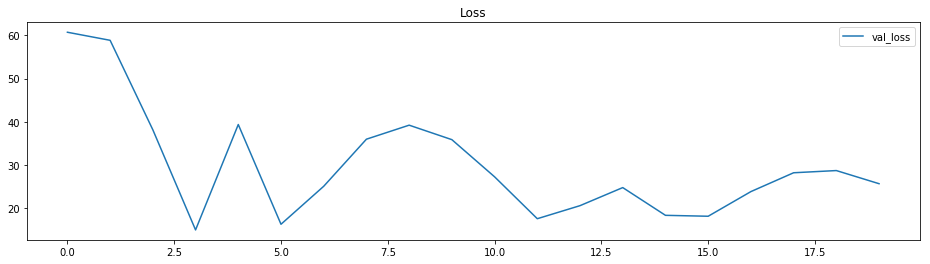

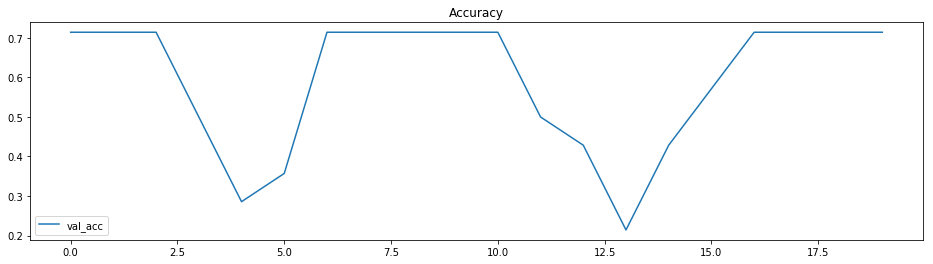

In [15]:
print(history)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(history)
#display(df)

df.plot(y=['val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['val_acc'], figsize=(16,4), title='Accuracy');

## Pruebas unitarias

In [16]:
def predict(prediction, file_name = 'cat.jpg'):
    #try: 
    #    file_name = 'cat.jpg'
    #except IndexError:
    #    print ('please enter image file path.........')
    #    exit()
    image_input = getvector(file_name).reshape((1,2048))
    if 'cat' in file_name:
        image_label = [[1, 0]]
    else:
        image_label = [[0, 1]]

    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('testsave.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))

        pred = sess.run(prediction, feed_dict={inputs: image_input})

        return pred

INFO:tensorflow:Restoring parameters from /home/grupoavatar/inf659-inception/transfer_learning/inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./testsave
Predict: cat.jpg



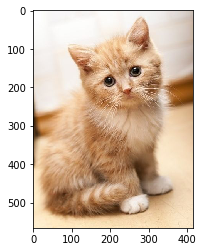

It's a cat: 0.23032298684120178, It's a dog: 0.7696769833564758




INFO:tensorflow:Restoring parameters from /home/grupoavatar/inf659-inception/transfer_learning/inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./testsave
Predict: dog.jpg



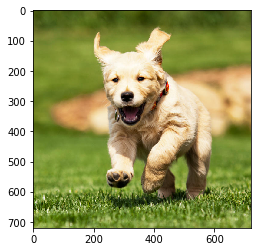

It's a cat: 0.4459637403488159, It's a dog: 0.5540362596511841


In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pred = predict(prediction, 'cat.jpg')
print('Predict: cat.jpg\n', )
img=mpimg.imread('cat.jpg')
imgplot = plt.imshow(img)
plt.show()
print ('It\'s a cat: {}, It\'s a dog: {}'.format(pred[0][0], pred[0][1]))
print('\n\n\n')

pred = predict(prediction, 'dog.jpg')
print('Predict: dog.jpg\n', )
img=mpimg.imread('dog.jpg')
imgplot = plt.imshow(img)
plt.show()
print ('It\'s a cat: {}, It\'s a dog: {}'.format(pred[0][0], pred[0][1]))